# Tox21 NR-AR Toxicity Prediction

## Introduction

Chemical toxicity prediction is a critical challenge in drug discovery and environmental health, as experimental toxicity testing is time-consuming, expensive, and ethically constrained. Computational approaches provide a scalable alternative by leveraging molecular structure data to identify compounds with potential toxic effects before laboratory validation. The Tox21 dataset, developed through a collaboration between the NIH, EPA, and FDA, offers a benchmark collection of chemical compounds annotated with biological assay outcomes, enabling the development and evaluation of predictive toxicity models.

In this project, we focus on predicting NR-AR (Nuclear Receptor-Androgen Receptor) activity, a biologically relevant endpoint associated with endocrine disruption. Using molecular representations derived from Morgan fingerprints and selected RDKit physicochemical descriptors, we construct machine learning models to classify compounds as active (toxic) or inactive. The dataset presents a significant class imbalance, with active compounds representing a small minority of samples, making this task particularly challenging and realistic for real-world toxicity screening.

To address this problem, we compare multiple modeling approaches, including Logistic Regression, Random Forest, and XGBoost, and explore strategies for handling class imbalance such as SMOTE oversampling and class-weighted learning. Model performance is evaluated using metrics that are well-suited for imbalanced classification, including AUROC, precision, recall, F1-score, and confusion matrices.
Beyond predictive performance, this project emphasizes model interpretability. Feature importance analysis and SHAP (SHapley Additive exPlanations) are used to identify which molecular fingerprint bits and descriptors most strongly influence NR-AR toxicity predictions. Additionally, select fingerprint bits are mapped back to representative chemical substructures to provide structural insight into patterns associated with toxic behavior.

Overall, this work demonstrates how interpretable machine learning methods can be applied to molecular data to support early-stage toxicity screening, offering both predictive accuracy and meaningful chemical insight.

### Environment & Dependencies

This project was developed using a Conda environment with the following key libraries:

- **RDKit**  
  Used for molecular structure handling, Morgan fingerprint generation, and chemical substructure visualization.

- **imbalanced-learn (imblearn)**  
  Applied to address severe class imbalance in the NR-AR toxicity dataset using SMOTE oversampling.

- **SHAP (SHapley Additive exPlanations)**  
  Used to interpret model predictions by identifying which molecular fingerprint bits and descriptors most strongly influence toxicity predictions.

All required packages were installed via **conda-forge** and were available at runtime.

In [6]:
!conda install -y -c conda-forge rdkit

!conda install -y -c conda-forge imbalanced-learn

!conda install -y -c conda-forge shap

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



## 2. Data Loading and Cleaning

### Import Libraries

In [9]:
# =========================
# Core Python Libraries
# =========================
import numpy as np
import pandas as pd

# =========================
# Chemistry & Structure (RDKit)
# =========================
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem, Draw, Descriptors, rdFingerprintGenerator

# =========================
# Modeling & Evaluation
# =========================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay,
)

from xgboost import XGBClassifier

# =========================
# Class Imbalance Handling
# =========================
from imblearn.over_sampling import SMOTE

# =========================
# Model Explainability
# =========================
import shap

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")


### Tox21 NR-AR Dataset

In this project, I use the **Tox21 10K dataset**, released by the U.S. National Institutes of Health (NIH) / NCATS as part of the 2014 Tox21 Data Challenge.

**Dataset details:**
- **File name:** `tox21_10k_data_all.sdf`
- **Format:** Structure Data File (SDF) containing approximately 10,000 small molecules

Each record in the SDF file includes:
- A chemical structure
- Basic molecular properties (e.g., molecular formula, molecular weight)
- Experimental readouts for multiple toxicity-related assays  
  - 7 nuclear receptor assays  
  - 5 stress-response assays  

This analysis focuses specifically on the **NR-AR (androgen receptor)** assay, where compounds are labeled as:
- **0** — inactive  
- **1** — active (toxic)

The original Tox21 dataset is publicly available at:  
https://tripod.nih.gov/tox21/challenge/data.jsp


### Load the SDF File (Tox21 10K) and Clean DataFrame

In [12]:
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")  #hides RDKit warning spam

# ===========================================
# Path to the Tox21 SDF file in Google Drive
# ============================================
filepath = r"/Users/almalechuga/Library/CloudStorage/GoogleDrive-alma.lechugaramos@eastern.edu/My Drive/DTSC 691 Project/Project Completion/tox21_10k_data_all.sdf"

df = PandasTools.LoadSDF(
    filepath,
    smilesName="smiles",
    molColName="mol",
    includeFingerprints=False
)

before = len(df)
df = df[df["mol"].notna()].reset_index(drop=True)
after = len(df)

print(f"Loaded {before:,} rows from SDF.")
print(f"Kept {after:,} rows with valid RDKit molecules (dropped {before-after:,}).")

df.head()


Loaded 11,761 rows from SDF.
Kept 11,761 rows with valid RDKit molecules (dropped 0).


,Formula,FW,DSSTox_CID,SR-HSE,ID,smiles,mol,NR-AR,SR-ARE,NR-Aromatase,NR-ER-LBD,NR-AhR,SR-MMP,NR-ER,NR-PPAR-gamma,SR-p53,SR-ATAD5,NR-AR-LBD
0,C27H25ClN6,468.9806 (35.4535+224.2805+209.2465),25848,0,NCGC00178831-03,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...,<rdkit.Chem.rdchem.Mol object at 0x123777760>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C20H6Br4Na2O5,691.8542 (645.8757+22.9892+22.9892),5234,0,NCGC00166114-03,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,<rdkit.Chem.rdchem.Mol object at 0x123777530>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C47H83NO17,934.1584 (916.1205+18.0379),28909,0,NCGC00263563-01,CO[C@@H]1[C@@H](OC)[C@H](C)[C@@](O)(CC(=O)[O-]...,<rdkit.Chem.rdchem.Mol object at 0x16360c7b0>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C52H54N4O12,927.0048 (329.4575+89.0275+89.0275+329.4575+90...,5513,1,NCGC00013058-02,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...,<rdkit.Chem.rdchem.Mol object at 0x16360c890>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C66H87N17O14,1342.5025 (1282.4505+60.0520),26683,NaN,NCGC00167516-01,CC(=O)O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=...,<rdkit.Chem.rdchem.Mol object at 0x16360c9e0>,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# ==========================================
# Creating a cleaner dataset for the target 
# ==========================================
target = "NR-AR"
df_nr_ar = df[df[target].notna()].copy()

# Checking size
df_nr_ar.shape

(9360, 18)

In [14]:
# ==========================================================
# checking actives vs inactives to identify class imbalance 
# ==========================================================
df_nr_ar[target].value_counts()

NR-AR
0    8980
1     380
Name: count, dtype: int64

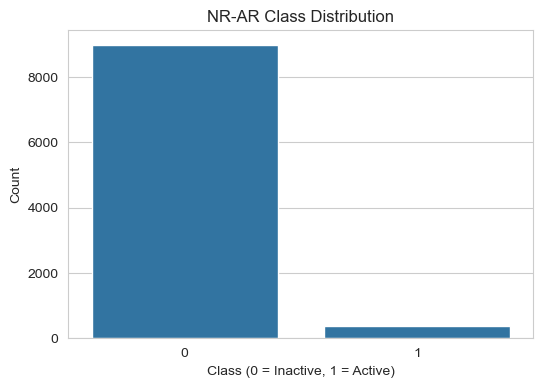

In [15]:
# =====================
# Visual of Imbalances
# =====================
plt.figure(figsize=(6,4))
sns.countplot(data=df_nr_ar, x=target)
plt.title("NR-AR Class Distribution")
plt.xlabel("Class (0 = Inactive, 1 = Active)")
plt.ylabel("Count")
plt.show()

**The dataset is highly imbalanced, with only 4% of compounds labeled active for NR-AR.** 

## 3. Feature Engineering

To represent molecular structures numerically, I generated two complementary feature sets:

1. **Morgan fingerprints (2048-bit, radius = 2)** to capture substructural patterns associated with toxicity.
2. **Physicochemical descriptors** (e.g., molecular weight, LogP, TPSA) to provide interpretable chemical properties.

These features were concatenated into a single feature matrix for downstream modeling.


In [19]:
# ============================
# RDKit Molecular Descriptors
# ============================

# We compute several physicochemical descriptors for each molecule
# and visualize how their distributions differ between NR-AR inactive (0) and active (1) compounds.

def compute_descriptors(mol):
    return {
        "MolWt": Descriptors.MolWt(mol),                 # molecular weight
        "LogP": Descriptors.MolLogP(mol),                # lipophilicity
        "TPSA": Descriptors.TPSA(mol),                   # polar surface area
        "HBD": Descriptors.NumHDonors(mol),              # H-bond donors
        "HBA": Descriptors.NumHAcceptors(mol),           # H-bond acceptors
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "AromaticRings": Descriptors.NumAromaticRings(mol),
    }

# Compute descriptors and add them as columns to df_nr_ar
desc_df = df_nr_ar["mol"].apply(compute_descriptors).apply(pd.Series)
df_nr_ar = pd.concat([df_nr_ar, desc_df], axis=1)


In [20]:
# =======================================
# Morgan Fingerprints Feature Extraction
# =======================================

# We convert chemical structures into 2048-bit Morgan fingerprints so that machine learning algorithms can learn 
# patterns associated with toxicity.

# Morgan fingerprint generator (ECFP-like)
n_bits = 2048
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)

def mol_to_morgan_fp(mol):
    fp = morgan_gen.GetFingerprint(mol)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


In [21]:
# Collect RDKit Molecular Descriptors from previous computation
descriptor_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RotatableBonds", "AromaticRings"]

# ==============================================================
# Combine Descriptors + Fingerprints for Final Feature Matrix X
# ==============================================================

X_fp = np.vstack(df_nr_ar["mol"].apply(mol_to_morgan_fp).values)
X_desc = df_nr_ar[descriptor_cols].values
X = np.hstack([X_fp, X_desc])

# Extract Labels (y)
y = df_nr_ar["NR-AR"].astype(int).values

print("New feature matrix shape:", X.shape)


New feature matrix shape: (9360, 2055)


## 4. Exploratory Data Analysis (EDA)

Before moving into model training, I explored the dataset to better understand the target variable and the overall structure of the data. This includes checking the class distribution for the NR-AR assay, since toxicity datasets are often highly imbalanced, and looking at basic molecular properties to see how active and inactive compounds compare.

The goal of this EDA is not to make strong statistical claims, but to build intuition about the data, identify potential challenges (such as class imbalance), and ensure the features being used are reasonable for downstream modeling.

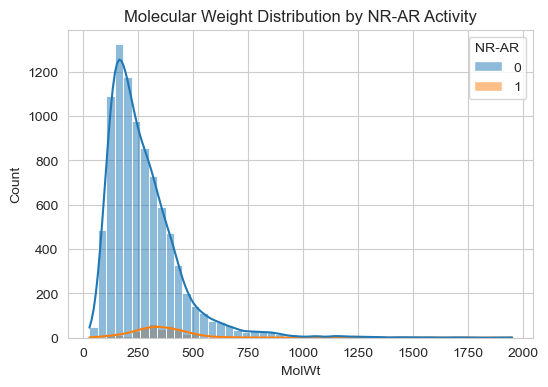

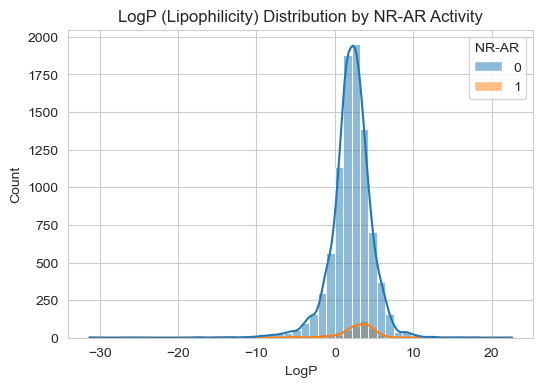

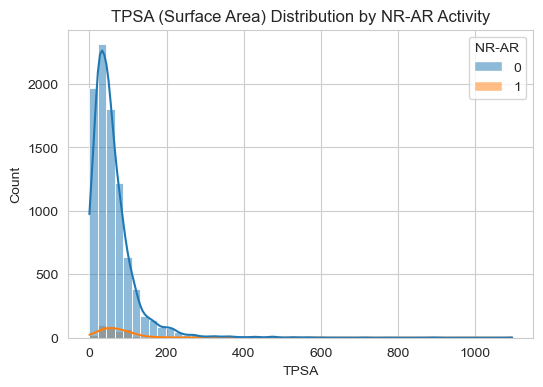

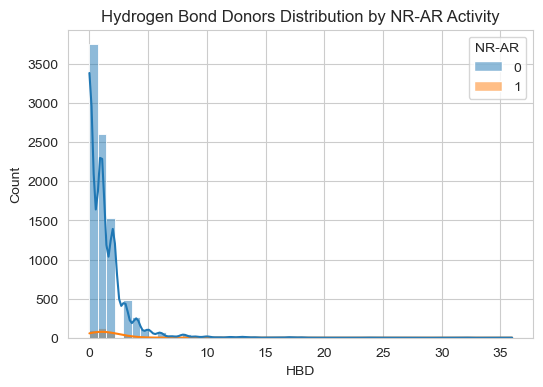

In [24]:
# =====================================================
# Visualize descriptor distributions by NR-AR activity
# =====================================================

def plot_descriptor(df, column, title):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=column, hue="NR-AR", bins=50, kde=True)
    plt.title(f"{title} Distribution by NR-AR Activity")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

plot_descriptor(df_nr_ar, "MolWt", "Molecular Weight")
plot_descriptor(df_nr_ar, "LogP", "LogP (Lipophilicity)")
plot_descriptor(df_nr_ar, "TPSA", "TPSA (Surface Area)")
plot_descriptor(df_nr_ar, "HBD", "Hydrogen Bond Donors")

**MolWt**
The molecular weight distributions for active and inactive compounds appear similar, suggesting that molecular size alone is not a strong driver of androgen receptor activity.

**LogP**
Active compounds show slightly higher LogP (hydrophobicity), suggesting that NR-AR activity may be influenced by lipophilicity.

**TPSA**
Both active and inactive compounds cluster at low TPSA, meaning surface polarity does not strongly differentiate toxicity for this target.

**HBD (Hydrogen Bond Donors)**
Most compounds (active and inactive) have low HBD values, so hydrogen-bond donation alone is not a strong indicator of NR-AR toxicity

### Correlation Heatmap of Descriptors

To better understand the relationships between the molecular descriptors used in this analysis, I examined their pairwise correlations. This helps identify features that may be strongly related to one another, which is useful for interpreting model behavior and understanding potential redundancy among descriptors.

The heatmap below shows the Pearson correlation coefficients between key physicochemical properties computed using RDKit.

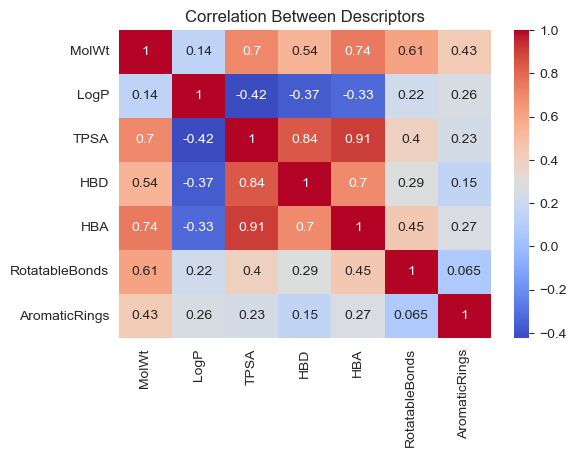

In [28]:
plt.figure(figsize=(6,4))
sns.heatmap(df_nr_ar[descriptor_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Descriptors")
plt.show()

### Heatmap Analysis

Several notable patterns emerge from the correlation heatmap:
- **TPSA, HBD, and HBA** show strong positive correlations with each other, which is expected since these descriptors all relate to molecular polarity and hydrogen bonding capacity.
- **Molecular weight (MolWt)** is moderately correlated with TPSA, HBD, HBA, and Rotatable Bonds, reflecting that larger molecules tend to have more functional groups and structural complexity.
- **LogP** is negatively correlated with TPSA and hydrogen bonding descriptors, suggesting that more lipophilic compounds tend to be less polar and have fewer hydrogen-bonding features.
- **Aromatic Rings** show relatively weak correlations with most other descriptors, indicating that aromaticity provides information that is largely independent of size and polarity.

Overall, no single descriptor shows an extremely strong correlation with toxicity on its own, reinforcing the need for machine learning models that can capture nonlinear interactions between multiple molecular features rather than relying on individual properties.

## 5. Modeling and Evaluations

Now that the data is cleaned and features are built, the next step is training a few classification models to predict **NR-AR activity** (0 = inactive, 1 = active/toxic).

Because the dataset is **imbalanced** (far more inactive than active compounds), I use a **stratified train/test split** to keep the class ratio consistent in both sets. For evaluation, I focus on:
- **AUROC** (how well the model separates classes overall)
- **Precision / Recall / F1-score**, especially for the **toxic (1)** class, since missing toxic compounds (false negatives) is more costly in screening.

I start with a **Logistic Regression baseline** (with class weighting), then compare it to more flexible models like **Random Forest** and **XGBoost**, and finally use **SMOTE** to test whether balancing the training data improves minority-class detection.


### Train-test Split

In [33]:
# ====================================
# Stratified preserve class imbalance 
# ====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

### Logistic Regression (baseline)

In [35]:
log_reg = LogisticRegression(
    max_iter=10000,          # increased to reduce convergence warning
    class_weight="balanced", # penalizes minority class mistakes more
    solver="lbfgs",
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

# ============
# Predictions
# ============
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# ===========
# Evaluation
# ===========
auroc = roc_auc_score(y_test, y_proba)
print(f"Logistic Regression AUROC: {auroc:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))


Logistic Regression AUROC: 0.881

              precision    recall  f1-score   support

           0      0.986     0.960     0.973      1796
           1      0.419     0.684     0.520        76

    accuracy                          0.949      1872
   macro avg      0.703     0.822     0.746      1872
weighted avg      0.963     0.949     0.955      1872



**Analysis:** 
The Logistic Regression baseline achieved an AUROC of 0.881, indicating good overall ability to distinguish between toxic and non-toxic compounds. High precision and recall for the non-toxic class show that the model performs well on the majority class. However, performance on the toxic class was weaker, with lower precision despite moderate recall, reflecting the impact of class imbalance and the limitations of a linear model.

### Random Forest Model

In [38]:
rf = RandomForestClassifier(
    n_estimators=400,         
    max_depth=None,          
    class_weight="balanced", 
    random_state=42,
    n_jobs=-1                 
)

rf.fit(X_train, y_train)

# ============
# Predictions
# ============
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# ===========
# Evaluation
# ===========
print("Random Forest AUROC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest AUROC: 0.8767656195053335
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1796
           1       0.75      0.64      0.70        76

    accuracy                           0.98      1872
   macro avg       0.87      0.82      0.84      1872
weighted avg       0.98      0.98      0.98      1872



**Analysis:**
The Random Forest model achieved an AUROC of approximately 0.88, indicating strong overall discrimination between toxic and non-toxic compounds, comparable to the baseline model. Unlike Logistic Regression, Random Forest showed improved performance on the toxic class, with higher precision and a stronger balance between precision and recall. This indicates fewer false positives while still identifying a meaningful portion of toxic compounds.

Overall, the improved minority-class performance reflects Random Forest’s ability to model complex, non-linear relationships within high-dimensional molecular fingerprints, making it more suitable for toxicity prediction in this imbalanced dataset.

In [95]:
import joblib

# Save final Random Forest model
joblib.dump(rf, "tox21_nr_ar_random_forest.joblib")

# Save fingerprint configuration
fp_config = {
    "radius": 2,
    "n_bits": 2048,
    "use_chirality": False
}
joblib.dump(fp_config, "fp_config.joblib")

print("Final Random Forest model and fingerprint config saved.")


Final Random Forest model and fingerprint config saved.


### XGBoost Model

In [41]:
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) / sum(y_train)),  # handles imbalance
    eval_metric="auc"
)

xgb.fit(X_train, y_train)

# ============
# Predictions
# ============
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# ===========
# Evaluation
# ===========
print("XGBoost AUROC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost AUROC: 0.8851871117102332
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1796
           1       0.59      0.68      0.63        76

    accuracy                           0.97      1872
   macro avg       0.79      0.83      0.81      1872
weighted avg       0.97      0.97      0.97      1872



**Analysis:**
The XGBoost model achieved an AUROC of approximately 0.89, indicating strong overall discrimination between toxic and non-toxic compounds. The model showed improved recall for the toxic class compared to Logistic Regression, meaning it identified a larger proportion of toxic compounds, though this came with lower precision and a higher false-positive rate.

Overall, XGBoost demonstrated strong predictive capability and sensitivity to the minority class. However, compared to Random Forest, its trade-off between precision and recall was less balanced, making Random Forest a more stable choice for final toxicity prediction in this imbalanced dataset.

### SMOTE (Training Set Only)

Because NR-AR is highly imbalanced, I used **SMOTE** to oversample the minority class **only in the training data**.  
The test set is left untouched so performance still reflects a realistic evaluation.

In [44]:
# SMOTE: resample ONLY the training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Training toxic (before SMOTE): {int(y_train.sum())}")
print(f"Training toxic (after  SMOTE): {int(y_train_res.sum())}")


Training toxic (before SMOTE): 304
Training toxic (after  SMOTE): 7184


### Random Forest with SMOTE data

Next, I trained a Random Forest on the SMOTE-balanced training set and evaluated it on the original (imbalanced) test set to see whether oversampling improves detection of the toxic class.

In [47]:
rf_smote = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight=None,      # we don't need class_weight now because SMOTE balanced the data
    random_state=42,
    n_jobs=-1
)

rf_smote.fit(X_train_res, y_train_res)

# ============
# Predictions
# ============
y_pred_rf_smote  = rf_smote.predict(X_test)
y_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

# ===========
# Evaluation
# ===========
print("Random Forest (SMOTE) AUROC:", roc_auc_score(y_test, y_proba_rf_smote))
print(classification_report(y_test, y_pred_rf_smote, digits=3))


Random Forest (SMOTE) AUROC: 0.8695785957097643
              precision    recall  f1-score   support

           0      0.986     0.996     0.991      1796
           1      0.862     0.658     0.746        76

    accuracy                          0.982      1872
   macro avg      0.924     0.827     0.868      1872
weighted avg      0.981     0.982     0.981      1872



**Analysis:** 
The Random Forest model trained on SMOTE-balanced data achieved an AUROC of approximately 0.87, indicating strong overall discrimination between toxic and non-toxic compounds. Compared to the non-SMOTE Random Forest, this model showed substantially improved precision for the toxic class, meaning fewer false positives when predicting toxicity, while maintaining reasonable recall.

However, this improvement came with a slight trade-off in overall balance and AUROC, suggesting that oversampling altered the class decision boundary. While SMOTE improved minority-class identification, the original Random Forest trained on imbalanced data provided a more stable balance between sensitivity and generalization on the untouched test set.

### Confusion Matrices

To better understand how each model performs beyond aggregate metrics, I visualize **confusion matrices** for all models.  
These plots highlight false positives and false negatives, which is especially important for toxicity prediction where missing a toxic compound can be costly.


In [50]:
def plot_conf_mat(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


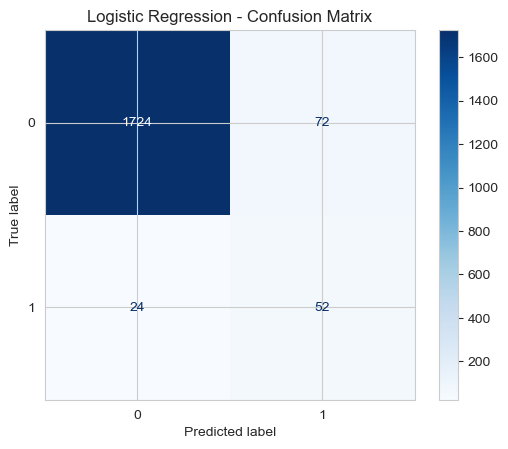

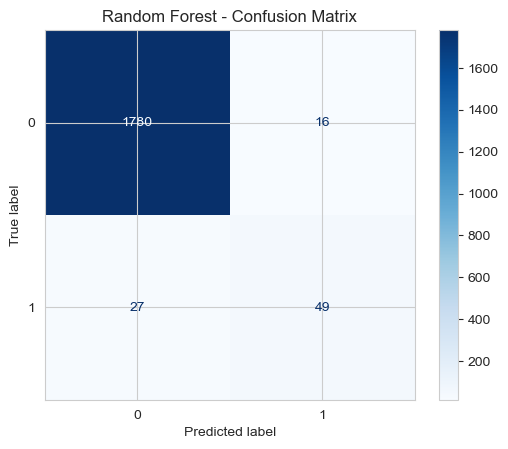

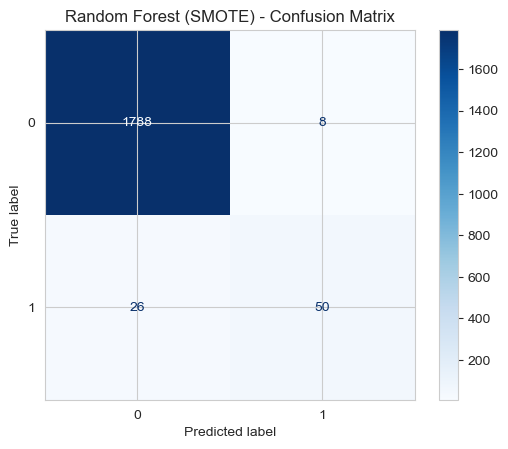

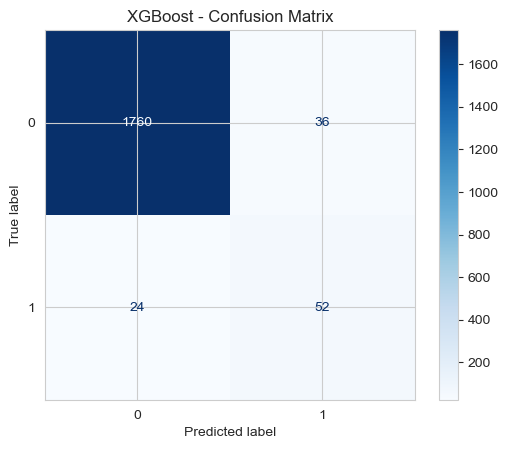

In [51]:
# =======================
# Display for Each Model
# =======================
plot_conf_mat("Logistic Regression", y_test, y_pred)
plot_conf_mat("Random Forest", y_test, y_pred_rf)
plot_conf_mat("Random Forest (SMOTE)", y_test, y_pred_rf_smote)
plot_conf_mat("XGBoost", y_test, y_pred_xgb)

### Confusion Matrix Analysis 

The confusion matrices highlight clear differences in how each model handles class imbalance. **Logistic Regression** correctly classified most non-toxic compounds but produced a relatively high number of false positives and false negatives for the toxic class, reflecting its limited ability to separate minority-class examples using a linear decision boundary.

The **Random Forest** model reduced false positives while maintaining a similar number of true positives for the toxic class, indicating a better balance between precision and recall. This suggests improved discrimination of toxic compounds without overly misclassifying non-toxic ones.

When **SMOTE** was applied to Random Forest, false positives were further reduced, improving precision for the toxic class. However, the number of missed toxic compounds remained similar, indicating that oversampling primarily shifted the decision boundary rather than dramatically increasing sensitivity.

The **XGBoost** model identified slightly more toxic compounds but at the cost of increased false positives, reflecting its higher recall but lower precision. Overall, the confusion matrices support the selection of the original Random Forest model as the most balanced approach for toxicity prediction on this imbalanced dataset.

### Best Overall Model: Random Forest (no SMOTE)
This model performed best when considering all three things that matter most in toxicity prediction:

**1. Strong discrimination**
- AUROC ≈ 0.88
- Comparable to Logistic Regression and XGBoost
- Indicates good separation between toxic and non-toxic compounds
  
**2. Best balance between precision & recall**
From confusion matrix:
- Fewer false positives than XGBoost
- Fewer missed toxic compounds than Logistic Regression
- More balanced than RF + SMOTE
  
This balance is critical in toxicity prediction, where:
- Too many false positives can lead to overly conservative screening
- Too many false negatives allow dangerous compounds to slip through
  
**3. Most stable generalization**
- Trained on the original imbalanced data
- Evaluated on an untouched test set
- Did not rely on synthetic samples (SMOTE), which can distort decision boundaries

This makes it the most realistic and trustworthy model for real-world use.

## 6. Modeling Interpretation (Feature Importance + SHAP)

Now that the model is trained, I want to peek inside and see what it’s actually using to make predictions.  
For the Random Forest, I start with built-in **feature importance** scores to identify which Morgan fingerprint bits contribute most to the model’s decisions.

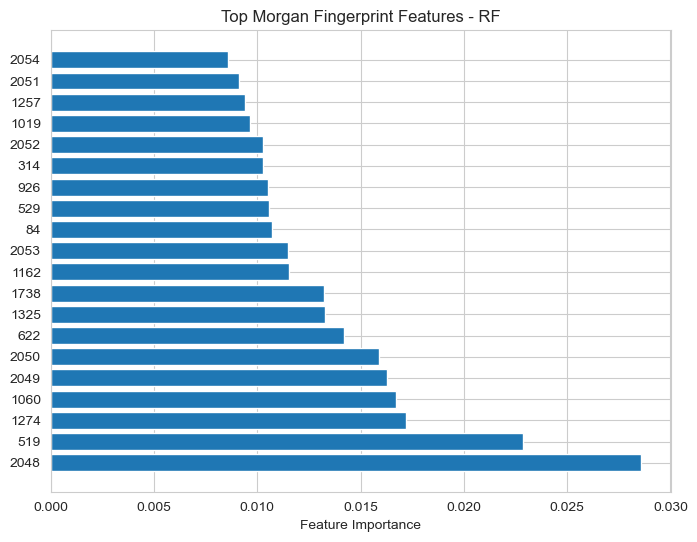

In [56]:
#Feature Importance - Top Morgan Fingerprint bits
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), indices)
plt.xlabel("Feature Importance")
plt.title("Top Morgan Fingerprint Features - RF")
plt.show()


**Analysis:**  
A small group of fingerprint bits stands out with noticeably higher importance, which suggests the model is relying on a few recurring structural patterns to separate NR-AR active vs inactive compounds.  
Since Morgan bits are not chemically interpretable on their own, I use **SHAP + substructure mapping** next to translate the top bits into actual chemical fragments.

### SHAP on Random Forest for toxic class

Feature importance tells us what features matter overall, but SHAP helps explain how features push predictions toward toxic vs. non-toxic.  
To keep runtime reasonable, I compute SHAP values on a small sample of the test set and visualize the most influential features.


Final vals shape: (300, 2055)
X_plot shape: (300, 2055)


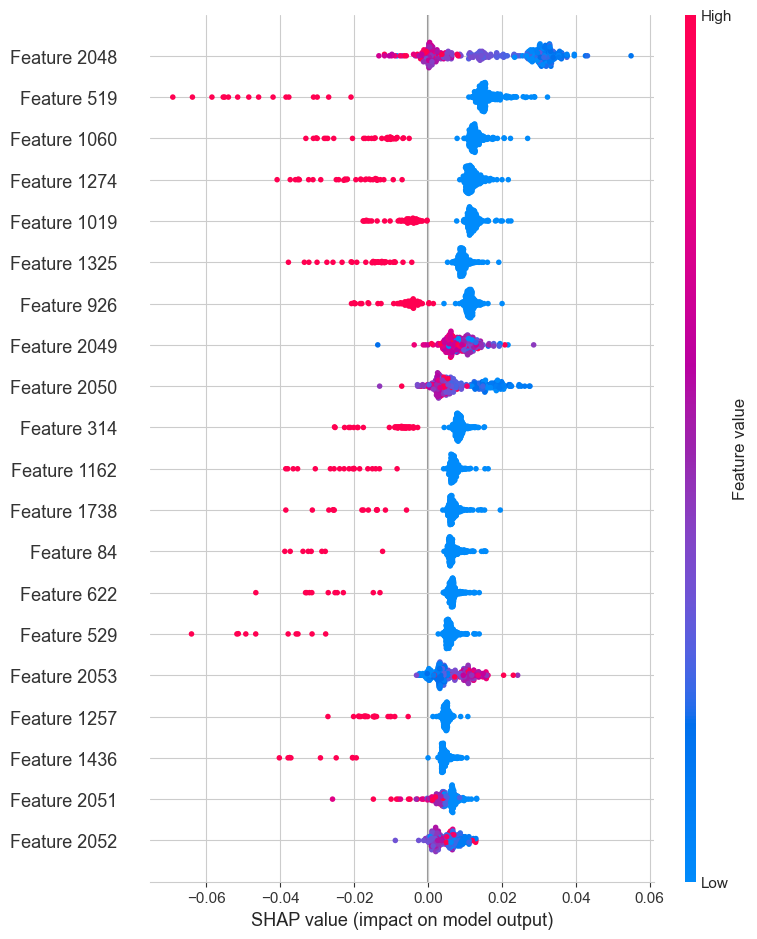

In [60]:
# 1. Use a smaller sample for speed
X_test_small = X_test[:300]

# Convert X_test to numpy for SHAP
if isinstance(X_test_small, pd.DataFrame):
    X_plot = X_test_small.values
else:
    X_plot = X_test_small

# 2. Build SHAP TreeExplainer
explainer = shap.TreeExplainer(rf)

# 3. Get SHAP values (disable additivity check for speed)
raw_shap = explainer.shap_values(X_plot, check_additivity=False)

# 4. Select class 1 as toxic and fix shape/orientation
if isinstance(raw_shap, list):
    vals = raw_shap[1]          # class 1 = toxic
else:
    vals = raw_shap

if vals.ndim == 3 and vals.shape[2] == 2:
    vals = vals[:, :, 0]  

# If it's transposed (features x samples), flip it
if vals.shape[0] == X_plot.shape[1] and vals.shape[1] == X_plot.shape[0]:
    vals = vals.T

# If there's an extra bias/offset column, drop it
if vals.shape[1] == X_plot.shape[1] + 1:
    vals = vals[:, :-1]

print("Final vals shape:", vals.shape)
print("X_plot shape:", X_plot.shape)

# 5. Summary plot for toxic class
shap.summary_plot(vals, X_plot)


We compute **SHAP** values on a subset of the test data (300 samples) to visualize which fingerprint bits most strongly influence NR-AR toxicity predictions. Morgan fingerprints generate 2048 binary features, and SHAP identifies which bits increase or decrease predicted toxicity.

### Map SHAP features back to fingerprints vs descriptors

In [63]:
# Average absolute SHAP value per feature
mean_abs_shap = np.mean(np.abs(vals), axis=0)

# Indices of top 15 features
top_idx = np.argsort(mean_abs_shap)[-15:][::-1]

print("Top SHAP features and what they represent:\n")
top_fingerprint_bits = []

for idx in top_idx:
    if idx < n_bits:
        # Morgan fingerprint bit
        print(f"Feature {idx}: Morgan fingerprint bit {idx}")
        top_fingerprint_bits.append(idx)
    else:
        # RDKit descriptors
        desc_name = descriptor_cols[idx - n_bits]
        print(f"Feature {idx}: RDKit descriptor '{desc_name}'")


Top SHAP features and what they represent:

Feature 2048: RDKit descriptor 'MolWt'
Feature 519: Morgan fingerprint bit 519
Feature 1060: Morgan fingerprint bit 1060
Feature 1274: Morgan fingerprint bit 1274
Feature 1019: Morgan fingerprint bit 1019
Feature 1325: Morgan fingerprint bit 1325
Feature 926: Morgan fingerprint bit 926
Feature 2049: RDKit descriptor 'LogP'
Feature 2050: RDKit descriptor 'TPSA'
Feature 314: Morgan fingerprint bit 314
Feature 1162: Morgan fingerprint bit 1162
Feature 1738: Morgan fingerprint bit 1738
Feature 84: Morgan fingerprint bit 84
Feature 622: Morgan fingerprint bit 622
Feature 529: Morgan fingerprint bit 529


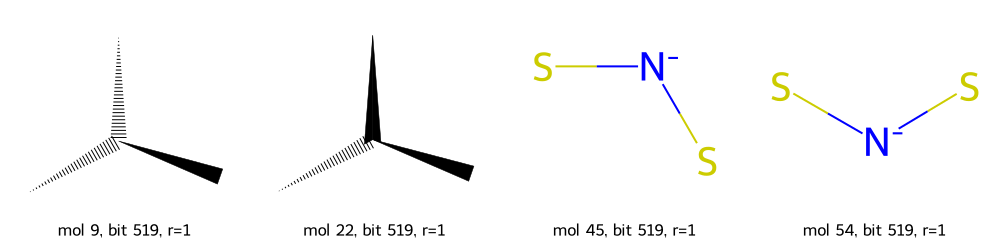

In [64]:
def visualize_bit_substructures(bit_id, n_examples=4):
    
    mols_to_draw = []
    legends = []

    for i, mol in enumerate(df_nr_ar["mol"]):
        if mol is None:
            continue

        bitInfo = {}
        # Regenerate fingerprint with bitInfo to get mapping
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol,
            radius=2,
            nBits=n_bits,
            bitInfo=bitInfo
        )


        if bit_id not in bitInfo:
            continue

        # Used first environment associated with this bit
        atom_idx, radius = bitInfo[bit_id][0]

        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        if not env:
            continue

        amap = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=amap)

        mols_to_draw.append(submol)
        legends.append(f"mol {i}, bit {bit_id}, r={radius}")

        if len(mols_to_draw) >= n_examples:
            break

    if not mols_to_draw:
        print(f"No molecules found with bit {bit_id} set.")
        return

    img = Draw.MolsToGridImage(
        mols_to_draw,
        legends=legends,
        molsPerRow=min(n_examples, 4),
        subImgSize=(250, 250)
    )
    display(img)

# Visualize the first 4 important fingerprint bits
visualize_bit_substructures(519, n_examples=4)

### SHAP Summary Interpretation

The SHAP summary plot indicates that the model’s predictions are primarily driven by a small number of molecular fingerprint bits, with the four most important features exhibiting the largest contributions to the toxic class. High values of these fingerprint bits are generally associated with positive SHAP values, increasing the likelihood of a toxic prediction, whereas low values contribute negatively and shift predictions toward non-toxicity. This concentration of importance among a limited set of features reflects the sparse and interpretable nature of fingerprint-based representations in cheminformatics.


## 7. Discussion and Limitations

This analysis shows that machine learning models can capture meaningful patterns related to NR-AR toxicity using molecular fingerprints. The selected model achieved reasonable predictive performance, indicating that structural features encoded in Morgan fingerprints contain relevant information. SHAP analysis further highlighted fingerprint bits that consistently influenced model predictions, improving interpretability at the model level.

Several limitations should be noted. The Tox21 dataset is based on high-throughput screening assays, which can be noisy and introduce labeling uncertainty. Additionally, molecular fingerprints are abstract representations of chemical structure, making direct biological interpretation of individual features challenging, even with SHAP explanations. Class imbalance between active and inactive compounds may also affect model stability and performance on the minority class. Finally, this study focuses on a single toxicity endpoint, and results may not generalize across other biological targets.

## 8. Conclusion

In this project, machine learning models were developed to predict androgen receptor (NR-AR) toxicity using molecular fingerprint representations from the Tox21 dataset. Among the models evaluated, the **Random Forest** classifier demonstrated the strongest overall performance, achieving the best balance between predictive accuracy and robustness on an imbalanced dataset. Its ensemble-based structure allowed it to capture non-linear relationships within high-dimensional fingerprint features more effectively than simpler models.

Beyond performance, Random Forest was selected as the final model due to its interpretability when combined with SHAP analysis. Feature importance results identified fingerprint bits that consistently contributed to toxicity predictions, offering insight into how molecular substructures influence model decisions. While these features do not map directly to specific chemical mechanisms, they provide a useful foundation for understanding structure–toxicity relationships at a model level.

Overall, this work highlights the potential of combining traditional machine learning models with explainability techniques to support toxicity prediction in early-stage drug discovery. Despite limitations related to dataset noise and feature abstraction, the results demonstrate that interpretable models can provide meaningful predictive signal and serve as a starting point for more advanced modeling approaches in future studies.